# Analysis of Simplified Humidity-Driven Flu Transmission Model ala Shaman et al.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from importlib import reload

from models import climate
reload(climate);

In [2]:
# %matplotlib notebook
# plt.rcParams['figure.figsize'] = [9.75, 6]
plt.rcParams['figure.figsize'] = [11, 6.5]
plt.rcParams['figure.max_open_warning'] = -1

## Base Assumptions

We derive the humidity data from average monthly relative humidity in Auckland, assume a temperature of 25 degrees Celcius

We assume the following parameter value choices:
- The background mortality rate is 1%, flu does not cause any mortality
- Vaccination waning rate is 90% per year, i.e. average immunisation effective duration is about 1 year and 1 month
- $R_0$ (secondary infection rate) is between 1.5 and 3.5
- Vaccination rate against a strain of flu is 60%
- We take the Shaman correlation for humidity effects on transmission

We start the epidemic off at 1 infection per 100,000 persons

We simulate the model for 100 years

We record the attack rate as the rate of new infection cases

## The model

<img src="lib/sir_flu_model.png" />

$$ \begin{bmatrix}\frac{dS}{dt} \\ \frac{dI}{dt} \\ \frac{dR}{dt} \\ \frac{dQ}{dt} \\ \frac{dL}{dt}\end{bmatrix} = \begin{bmatrix}\mu + \gamma R-(\mu+\beta(t)I+v(t))S \\ \beta(t)IS - (\mu+\alpha)I \\ \alpha I +v(t)S - (\mu+\gamma)R \\ u(t) \\ \beta - L\end{bmatrix}$$

$$ \beta(t) = (R_{0,min}+ (R_{0,max}-R_{0,min})e^{-aQ})(\mu+\alpha)$$

$$ v(t) = \begin{cases}v_c & \text{if } 0.25 < t \bmod 1  <0.5 \\ 0 & \text{otherwise}\end{cases} $$

$u(t)$ is based on actual humidity data (acts like a system input ala. control systems).

$S$ is the proportion of susceptibles in the population.

$I$ is the proportion of infected in the population.

$R$ is the proportion of recovered/immune in the population.

$Q$ is the specific humidity.

$L$ is the attack rate.

In [3]:
# implementation
import inspect
print(inspect.getsource(climate.model))

def model(t, state, parameters, switches):

    s, i, r, q, l = state
    mu, gm, rmin, rmax, al, v, a = parameters

    # switch humidity model
    if not switches[0]:
        dq = DQ
    else:
        dq = lambda t: 0

    # switch vaccination rate model
    if switches[1] == 0:
        vacc = lambda t: 10/4*v*ca.mod(t,1)*(1-ca.mod(t, 1)**2)**4
    elif switches[1] > 0:
        vacc = lambda t: 0.25*v
    elif switches[1] < 0:
        vacc = lambda t: v if t%1 > 0.25 and t%1 < 0.5 else 0

    bt = (rmin + (rmax-rmin)*np.exp(-a*q))*(mu+al)
    return [
        mu + gm*r - (mu + bt*i + vacc(t))*s,
        bt*i*s - (mu + al)*i,
        al*i + vacc(t)*s - (mu + gm)*r,
        dq(t),
        bt - l,
    ]



## Baseline Model, no time dependent effects

In this model, we have humidity constant, and vaccination rate constant throughout the year

In [4]:
from scipy import integrate

parameters = [0.01, 0.9, 1.5, 3.5, 0.999, 0.6, 180]
def modelfn_autonomous(t, y):
    return climate.model(t, y, parameters, [1, 1])

infected_fraction = 1e-5
constant_humidity = np.mean(climate.HUMIDITY_DATA)

solution_an = integrate.solve_ivp(modelfn_autonomous, [0, 100], 
                                  [1-infected_fraction, infected_fraction, 0, constant_humidity, 0], 
                                  max_step=1/12, dense_output=True)
solution_an.message

'The solver successfully reached the end of the integration interval.'

In [5]:
T1 = solution_an.t
S1, I1, R1, Q1, L1 = solution_an.y

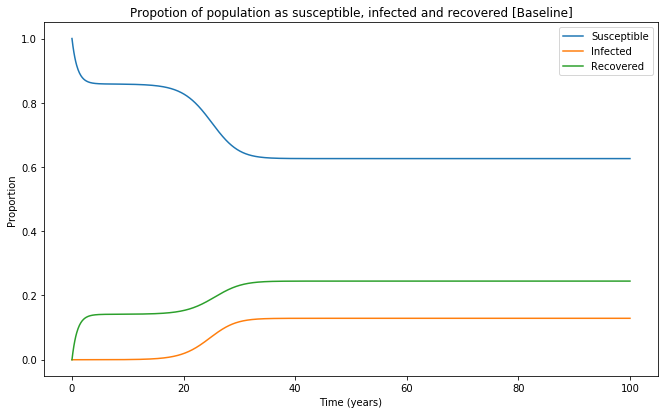

In [6]:
plt.figure()
plt.plot(T1, S1, T1, I1, T1, R1)
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.title("Propotion of population as susceptible, infected and recovered [Baseline]")
plt.xlabel("Time (years)")
plt.ylabel("Proportion");

We observe that there is an intermediary plateau between ~3-15 years after the initial epidemic season, this then ramps up to a higher baseline infected rate, which becomes stable at the ~25 year mark

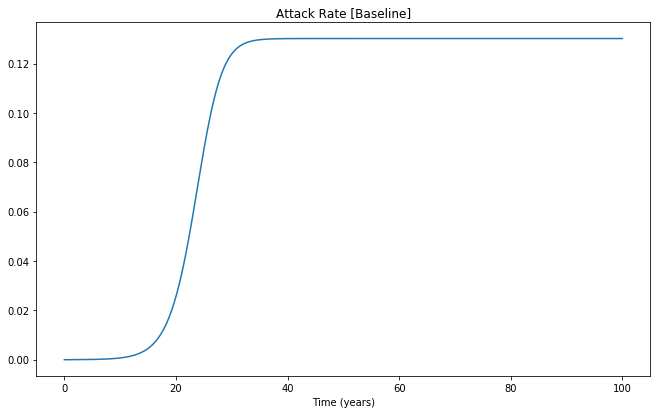

In [7]:
plt.figure()
plt.plot(T1, L1*S1*I1)
plt.title("Attack Rate [Baseline]")
plt.xlabel("Time (years)");

This attack rate will converge onto the the actual attack rate over time from the initial value of 0 cases, which we see stabilises around 16%.

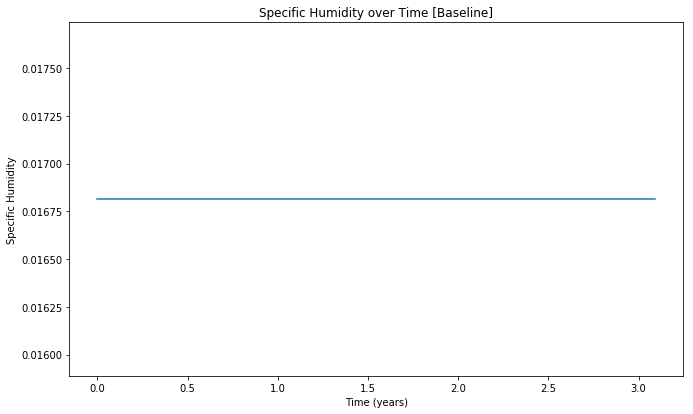

In [8]:
plt.figure()
plt.plot(T1[:40], Q1[:40])
plt.title("Specific Humidity over Time [Baseline]")
plt.xlabel("Time (years)")
plt.ylabel("Specific Humidity");

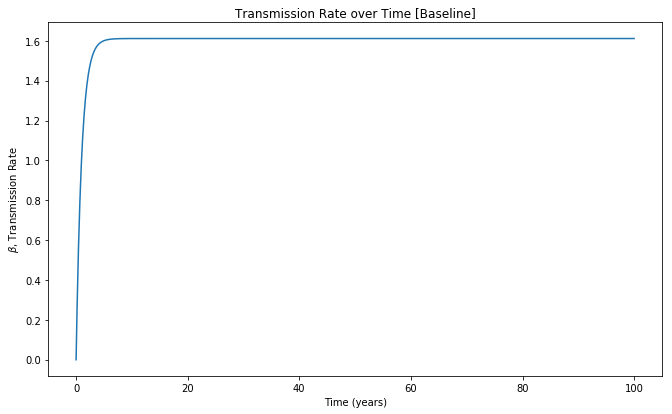

In [9]:
plt.figure()
plt.plot(T1, L1)
plt.title("Transmission Rate over Time [Baseline]")
plt.xlabel("Time (years)")
plt.ylabel(r"$\beta$, Transmission Rate");

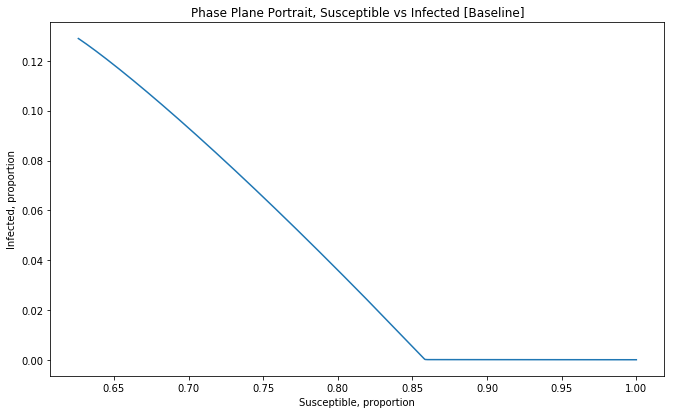

In [10]:
plt.figure()
plt.plot(S1, I1)
plt.title("Phase Plane Portrait, Susceptible vs Infected [Baseline]")
plt.xlabel("Susceptible, proportion")
plt.ylabel("Infected, proportion");

What's interesting to note here is that wihtout the time dependence, the deterministic system has a saddle point near where the "corner" in the trajectory is. We also note that the trajectory moves quite slowly towards this saddle point, and quickly away from it, if we consult the time series plots earlier.

## Adding Humidity Effects

We interpolate the humidity data we have for Auckland to create an annual humidity cycle

In [11]:
from IPython.display import Markdown as md

md(r"$q(t) \approx %f \sin(2\pi t-%f)+%f \\ q(0)=%f$"%(climate.COEFS[0], climate.COEFS[1], climate.COEFS[2], climate.Q0))

$q(t) \approx 0.001123 \sin(2\pi t-1.415459)+0.016906 \\ q(0)=0.016199$

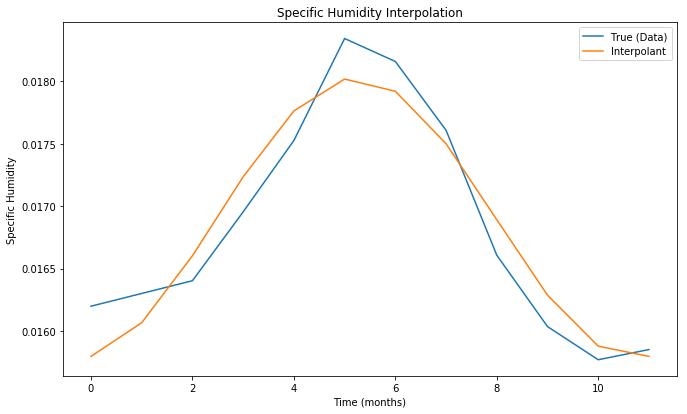

In [12]:
plt.figure()
plt.title("Specific Humidity Interpolation")
plt.plot(climate.HUMIDITY_DATA)
plt.plot(climate.HUMIDITY_FUNCTION(np.linspace(0,12,12), *climate.COEFS))
plt.legend(["True (Data)", "Interpolant"])
plt.xlabel("Time (months)")
plt.ylabel("Specific Humidity");

In [13]:
def modelfn_with_humidity(t, y):
    return climate.model(t, y, parameters, [0, 1])

solution_wh = integrate.solve_ivp(modelfn_with_humidity, [0, 100], 
                                  [1-infected_fraction, infected_fraction, 0, climate.Q0, 0], 
                                  max_step=1/12, dense_output=True)

In [14]:
T2 = solution_wh.t
S2, I2, R2, Q2, L2 = solution_wh.y

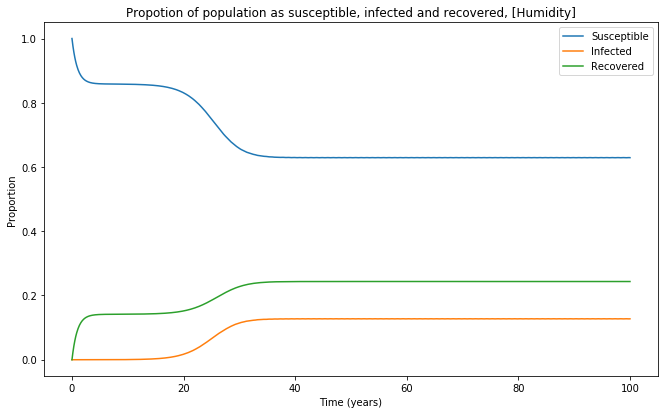

In [15]:
plt.figure()
plt.plot(T2, S2, T2, I2, T2, R2)
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.title("Propotion of population as susceptible, infected and recovered, [Humidity]")
plt.xlabel("Time (years)")
plt.ylabel("Proportion");

There does not seem to be a large difference between the model with humidity and the baseline. We can confirm this by plotting the differences

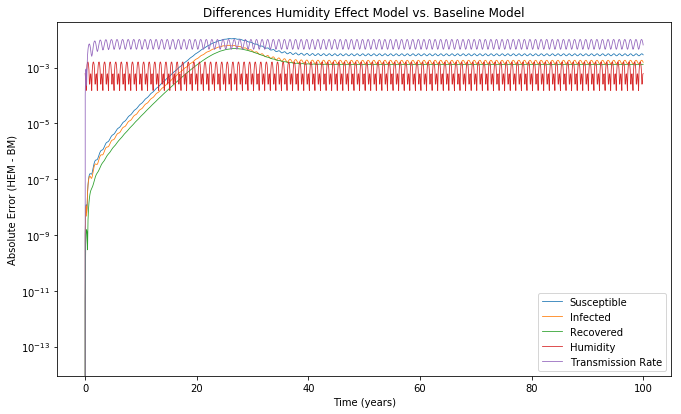

In [16]:
plt.figure()
plt.semilogy(T2, np.abs((solution_an.sol(T2) - solution_wh.y).T), linewidth=0.8)
plt.legend(["Susceptible", "Infected", "Recovered", "Humidity", "Transmission Rate"])
plt.title("Differences Humidity Effect Model vs. Baseline Model")
plt.ylabel("Absolute Error (HEM - BM)")
plt.xlabel("Time (years)");

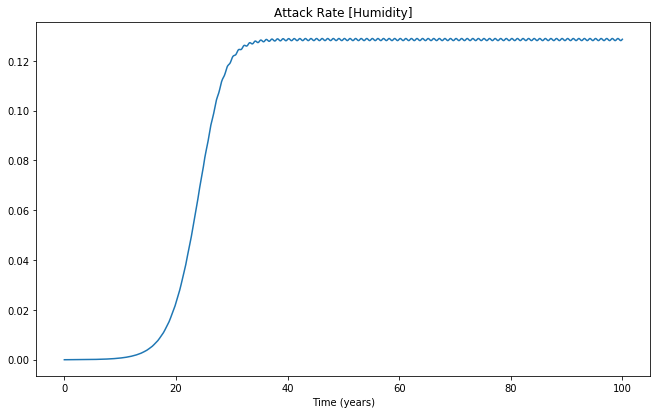

In [17]:
plt.figure()
plt.plot(T2, L2*S2*I2)
plt.title("Attack Rate [Humidity]")
plt.xlabel("Time (years)");

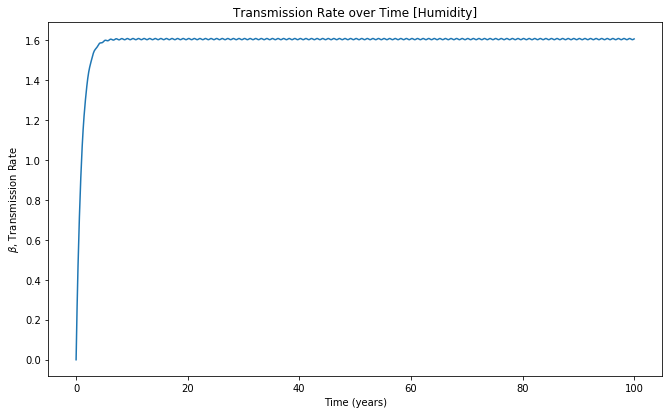

In [18]:
plt.figure()
plt.plot(T2, L2)
plt.title("Transmission Rate over Time [Humidity]")
plt.xlabel("Time (years)")
plt.ylabel(r"$\beta$, Transmission Rate");

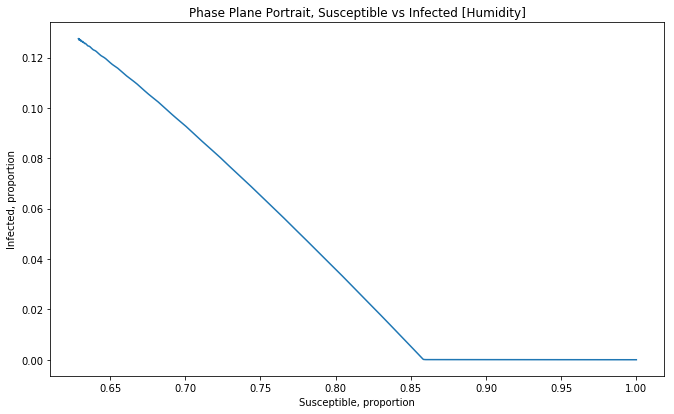

In [19]:
plt.figure()
plt.plot(S2, I2)
plt.title("Phase Plane Portrait, Susceptible vs Infected [Humidity]")
plt.xlabel("Susceptible, proportion")
plt.ylabel("Infected, proportion");

## Baseline with Seasonal Vaccination Effects

We can introduce seasonal vaccination rates in one of two forms: Autumn-only, Autumn-biased. In either case, it the vaccination rate is "applied" at different time of the year.

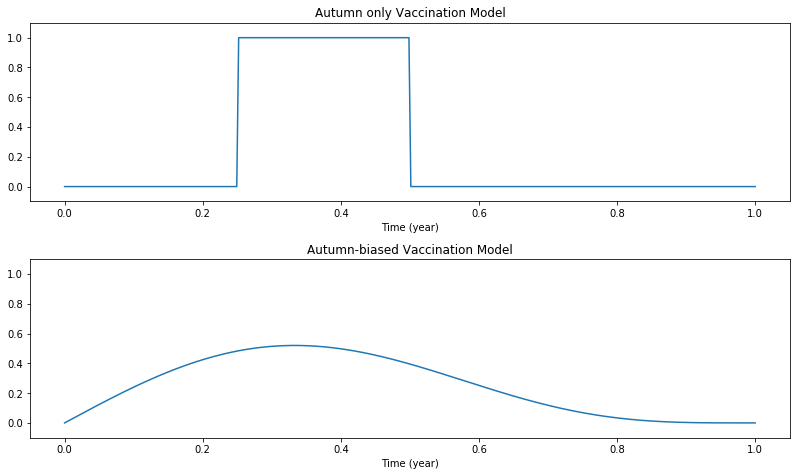

In [20]:
import casadi as ca

t_sample = np.linspace(0,1, 366)
v = 1

vacc_0 = lambda t: v if t%1 > 0.25 and t%1 < 0.5 else 0
vacc_1 = lambda t: 10/4*v*ca.mod(t,1)*(1-ca.mod(t, 1)**2)**4

vr_0 = [vacc_0(ti) for ti in t_sample]
vr_1 = [vacc_1(ti) for ti in t_sample]

fig, axs = plt.subplots(2, 1, constrained_layout=True)

axs[0].plot(t_sample, vr_0)
axs[0].set_ylim((-0.1, 1.1))
axs[0].set_title("Autumn only Vaccination Model")
axs[0].set_xlabel("Time (year)")

axs[1].plot(t_sample, vr_1)
axs[1].set_ylim((-0.1, 1.1))
axs[1].set_title("Autumn-biased Vaccination Model")
axs[1].set_xlabel("Time (year)");

In [21]:
def modelfn_vacc_effs_0(t, y):
    return climate.model(t, y, parameters, [1, -1])

def modelfn_vacc_effs_1(t, y):
    return climate.model(t, y, parameters, [1, 0])

solution_ve0 = integrate.solve_ivp(modelfn_vacc_effs_0, [0, 100], 
                                   [1-infected_fraction, infected_fraction, 0, constant_humidity, 0], 
                                   max_step=1/12, dense_output=True)
solution_ve1 = integrate.solve_ivp(modelfn_vacc_effs_1, [0, 100], 
                                   [1-infected_fraction, infected_fraction, 0, constant_humidity, 0], 
                                   max_step=1/12, dense_output=True)

In [22]:
T3 = solution_ve0.t
S3, I3, R3, Q3, L3 = solution_ve0.y

In [23]:
T4 = solution_ve1.t
S4, I4, R4, Q4, L4 = solution_ve1.y

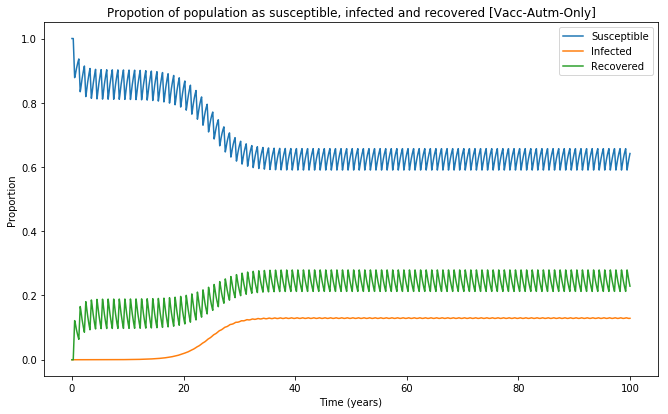

In [24]:
plt.figure()
plt.plot(T3, S3, T3, I3, T3, R3)
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.title("Propotion of population as susceptible, infected and recovered [Vacc-Autm-Only]")
plt.xlabel("Time (years)")
plt.ylabel("Proportion");

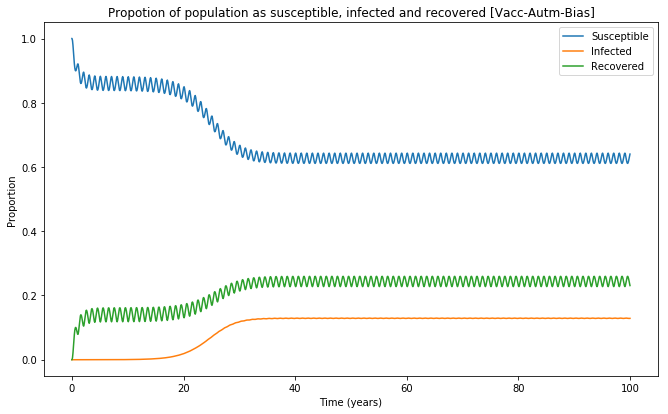

In [25]:
plt.figure()
plt.plot(T4, S4, T4, I4, T4, R4)
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.title("Propotion of population as susceptible, infected and recovered [Vacc-Autm-Bias]")
plt.xlabel("Time (years)")
plt.ylabel("Proportion");

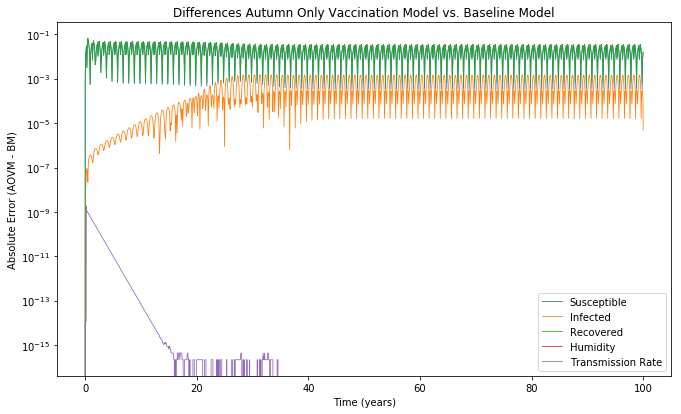

In [26]:
plt.figure()
plt.semilogy(T3, np.abs((solution_an.sol(T3) - solution_ve0.y).T), linewidth=0.8)
plt.legend(["Susceptible", "Infected", "Recovered", "Humidity", "Transmission Rate"])
plt.title("Differences Autumn Only Vaccination Model vs. Baseline Model")
plt.ylabel("Absolute Error (AOVM - BM)")
plt.xlabel("Time (years)");

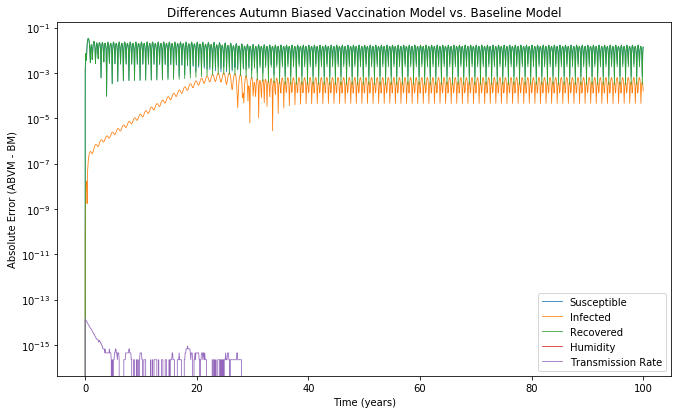

In [27]:
plt.figure()
plt.semilogy(T4, np.abs((solution_an.sol(T4) - solution_ve1.y).T), linewidth=0.8)
plt.legend(["Susceptible", "Infected", "Recovered", "Humidity", "Transmission Rate"])
plt.title("Differences Autumn Biased Vaccination Model vs. Baseline Model")
plt.ylabel("Absolute Error (ABVM - BM)")
plt.xlabel("Time (years)");

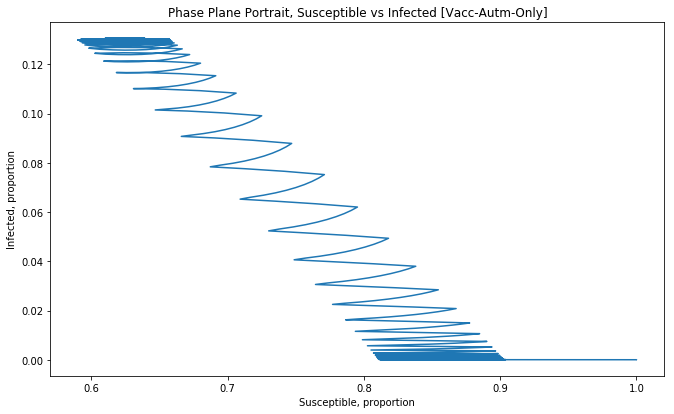

In [28]:
plt.figure()
plt.plot(S3, I3)
plt.title("Phase Plane Portrait, Susceptible vs Infected [Vacc-Autm-Only]")
plt.xlabel("Susceptible, proportion")
plt.ylabel("Infected, proportion");

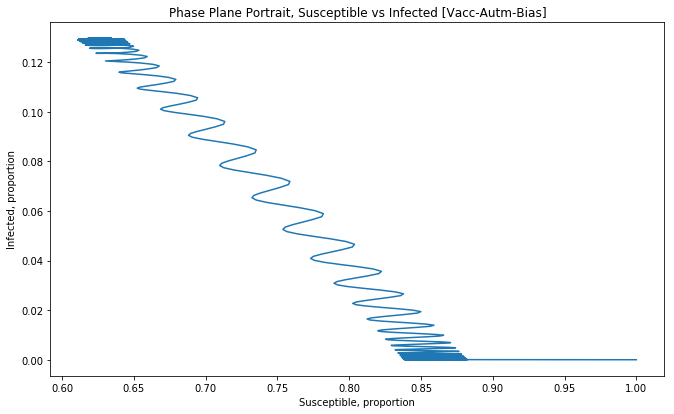

In [29]:
plt.figure()
plt.plot(S4, I4)
plt.title("Phase Plane Portrait, Susceptible vs Infected [Vacc-Autm-Bias]")
plt.xlabel("Susceptible, proportion")
plt.ylabel("Infected, proportion");

## A Full Model

We now look at the model with both humidity effects and vaccination rate effects. We will choose to use the Autumn-biased version of the vaccination model, purely so that we can differentiate it more readily in future, when we perform other tasks on the forward model

In [30]:
def full_model(t, y):
    return climate.model(t, y, parameters, [0, 0])

solution_full = integrate.solve_ivp(full_model, [0, 100], 
                                    [1-infected_fraction, infected_fraction, 0, climate.Q0, 0], 
                                    max_step=1/12, dense_output=True)


In [31]:
T = solution_full.t
S, I, R, Q, L = solution_full.y

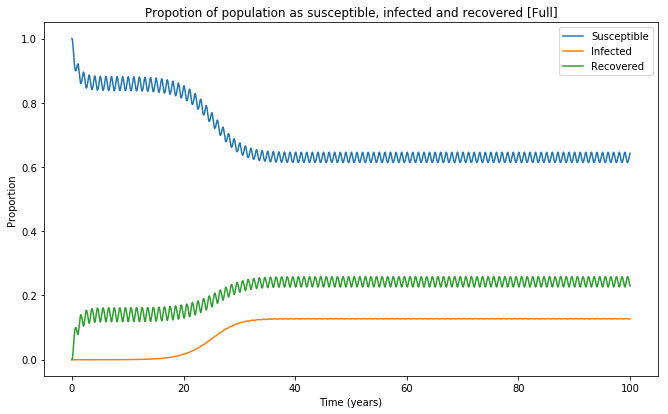

In [32]:
plt.figure()
plt.plot(T, S, T, I, T, R)
plt.legend(["Susceptible", "Infected", "Recovered"])
plt.title("Propotion of population as susceptible, infected and recovered [Full]")
plt.xlabel("Time (years)")
plt.ylabel("Proportion");

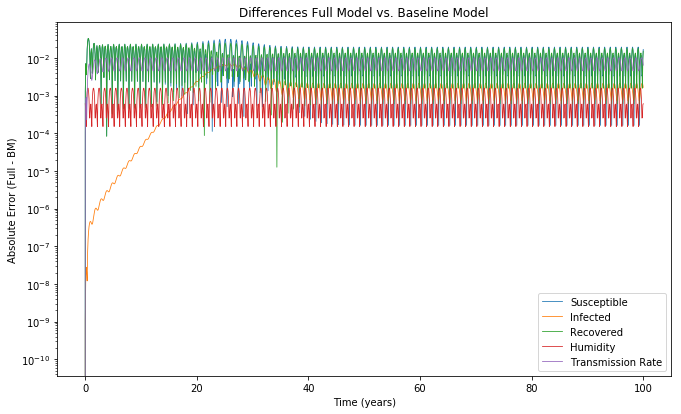

In [33]:
plt.figure()
plt.semilogy(T, np.abs((solution_an.sol(T) - solution_full.y).T), linewidth=0.8)
plt.legend(["Susceptible", "Infected", "Recovered", "Humidity", "Transmission Rate"])
plt.title("Differences Full Model vs. Baseline Model")
plt.ylabel("Absolute Error (Full - BM)")
plt.xlabel("Time (years)");

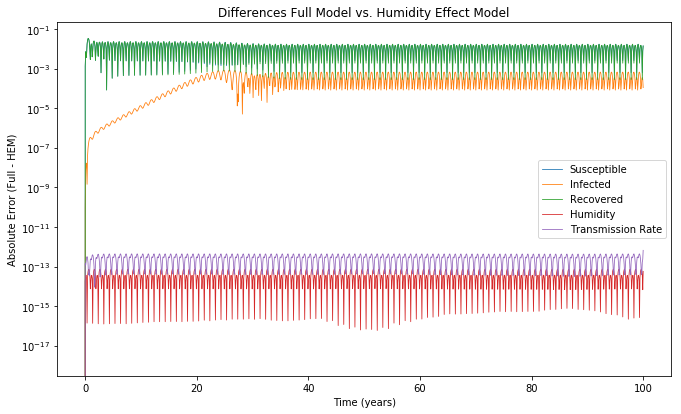

In [34]:
plt.figure()
plt.semilogy(T, np.abs((solution_wh.sol(T) - solution_full.y).T), linewidth=0.8)
plt.legend(["Susceptible", "Infected", "Recovered", "Humidity", "Transmission Rate"])
plt.title("Differences Full Model vs. Humidity Effect Model")
plt.ylabel("Absolute Error (Full - HEM)")
plt.xlabel("Time (years)");

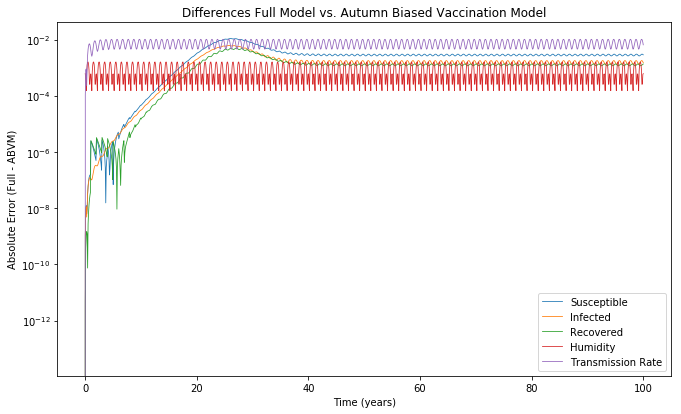

In [35]:
plt.figure()
plt.semilogy(T, np.abs((solution_ve1.sol(T) - solution_full.y).T), linewidth=0.8)
plt.legend(["Susceptible", "Infected", "Recovered", "Humidity", "Transmission Rate"])
plt.title("Differences Full Model vs. Autumn Biased Vaccination Model")
plt.ylabel("Absolute Error (Full - ABVM)")
plt.xlabel("Time (years)");

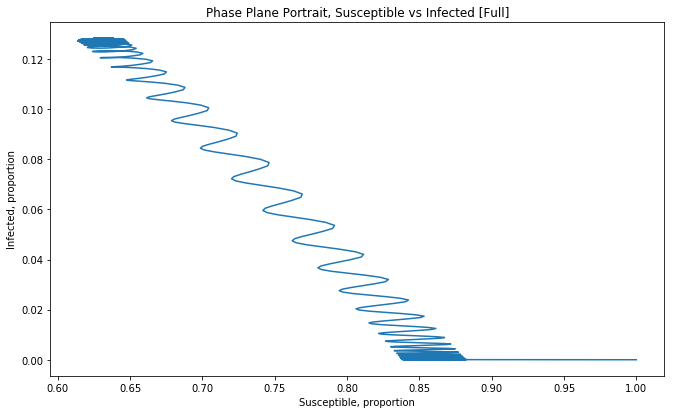

In [36]:
plt.figure()
plt.plot(S, I)
plt.title("Phase Plane Portrait, Susceptible vs Infected [Full]")
plt.xlabel("Susceptible, proportion")
plt.ylabel("Infected, proportion");

# Experimenting with Parameters

Note: in this set of derivations, we take $v$ to be the actual vaccination rate at any point in time, as opposed to the baseline that we modify in the simulations above

First we need to solve for the fixed points of the autonomous (baseline) system:

We get the fixed points:

1. $\left( \frac{\mu+\gamma}{\mu+\gamma+v}, 0 \right)$
2. $\left( \frac{\mu+\alpha}{\beta}, \frac{\mu+\gamma - (\mu+\gamma+v)(\frac{\mu+\alpha}{\beta})}{\mu+\alpha+\gamma}\right)$

We derive the Jacobian:

$J = \begin{bmatrix} -\mu-\gamma-v - \beta I & -\gamma-\beta S \\ \beta I & -\mu-\alpha+\beta S \end{bmatrix}$

giving:

$trJ = -2\mu - \gamma - v -\alpha + \beta(S-I)$

and

$detJ = (\mu^2+\alpha\mu+\gamma\mu+\alpha\gamma+v\mu+\alpha v)+\beta(\mu+\gamma+\alpha)I - \beta(\mu+\gamma+v)S$

We note that 

$\frac{\partial detJ}{\partial \mu} = -trJ$

## First ("trivial") fixed point

At the first fixed point we get

$trJ\left( \frac{\mu+\gamma}{\mu+\gamma+v}, 0 \right) = -(2\mu+\gamma+v+\alpha) + \frac{\beta(\mu+\gamma)}{\mu+\gamma+v}$

$detJ\left( \frac{\mu+\gamma}{\mu+\gamma+v}, 0 \right) = \mu^2+\alpha\mu+\gamma\mu+\alpha\gamma+v\mu+\alpha v - \beta\mu-\beta\gamma$

We can also derive the eigen values directly using Sage:

$\lambda_1 = \frac{-(\alpha\gamma + (\alpha + \gamma)\mu + \mu^2 - (\alpha\gamma + (\alpha + \gamma)\mu + \mu^2)p + (\alpha + \mu)v)}{\gamma + \mu + v}$

$\lambda_2 = -\gamma - \mu - v$

Making the substitution $\beta = (\mu+\alpha)R_0$ where $R_0=R_{0,\min}+(R_{0,\max}-R_{0,\min})\exp(-aq(t))$
we can derive the conditions for which this fixed point is a saddle:

$\lambda_1 > 0 \implies R_0 > \frac{\mu+\gamma+v}{\mu+\gamma}$ gives a saddle, stable otherwise.

This actually implies that our definition of $R_0$ is flawed, since we should expect the bifurcation at $R_0 = 1$

This means that we should really have

$\beta = \frac{(\mu+\alpha)(\mu+\gamma+v)}{\mu+\gamma}R_0$

i.e. $R_0 = \frac{(\mu+\gamma)\beta}{(\mu+\alpha)(\mu+\gamma+v)}$

## Second ("non-trivial") fixed point

What we first notice is that, other than a Hopf bifucation, there is no way for the stability of the trivial fixed point above to change stability without undergoing a bifurcation with this fixed point. Therefore when

$ p = \frac{\mu+\gamma+v}{\mu+\gamma} $

we expect the stability of this fixed point to change too.

Substituting in for the Jacobian, we get

$trJ\left( \frac{\mu+\alpha}{\beta}, \frac{\mu+\gamma - (\mu+\gamma+v)(\frac{\mu+\alpha}{\beta})}{\mu+\alpha+\gamma}\right) = -\frac{((\gamma + \mu)R_0 - \gamma - \mu - v)(\alpha + \mu)}{\alpha + \gamma + \mu} - \gamma - \mu - v$

We can show that the condition $trJ < 0$ is always true through algebraic manipulation to isolate the condition in terms of $R_0$.

We also require $detJ > 0$ for stability. We get

$detJ\left( \frac{\mu+\alpha}{\beta}, \frac{\mu+\gamma - (\mu+\gamma+v)(\frac{\mu+\alpha}{\beta})}{\mu+\alpha+\gamma}\right) = ((\gamma + \mu)R_0 - \gamma - \mu - v)(\alpha + \mu)$

Isolating for $R_0$ this condition gives us stabilty when

$\gamma R_0 + \mu R_0 - \gamma - \mu - v > 0 \implies R_0 > \frac{\gamma + \mu + v}{\gamma + \mu}$

We can also derive the condition for a spiral existing by solving for $trJ^2-4detJ < 0$

This gives us the condition that 

$R_0 > \frac{2\alpha^2 + 4\alpha\gamma + \gamma^2 + (4\alpha + 3\gamma)\mu + 2\mu^2 - \gamma v - 2(\alpha + \gamma + \mu)\sqrt{\alpha^2 + \alpha\gamma + \alpha\mu - (\alpha + \gamma + \mu)v}}{\alpha\gamma + (\alpha + \gamma)\mu + \mu^2} $ 

$R_0 < \frac{2\alpha^2 + 4\alpha\gamma + \gamma^2 + (4\alpha + 3\gamma)\mu + 2\mu^2 - \gamma v + 2(\alpha + \gamma + \mu)\sqrt{\alpha^2 + \alpha\gamma + \alpha\mu - (\alpha + \gamma + \mu)v}}{\alpha\gamma + (\alpha + \gamma)\mu + \mu^2}$

## Complete eradication

To get complete eradication in the system with parameters defined above, we solve the condition in the next cell

In [37]:
md(r"$R_0 < \frac{\gamma+\mu+v}{\mu+\gamma} = \frac{0.9+0.01+0.25(0.6)}{0.01+0.9} \approx %f$"%((0.9+0.01+0.25*0.6)/(0.01+0.9)))

$R_0 < \frac{\gamma+\mu+v}{\mu+\gamma} = \frac{0.9+0.01+0.25(0.6)}{0.01+0.9} \approx 1.164835$

As is obvious from the above recovered value of $R_0$, the formulation of it as $R_0 = \frac{\beta}{\mu+\alpha}$ is not accurately reflecting the model.

If we reanalyse the model with the construction $R_0 = \frac{\beta(\mu+\gamma)}{(\mu+\alpha)(\mu+\gamma+v)}$, we recover instead that the bifurcation occurs at $R_0=1$, which is then consistent with the definition of $R_0$ in the literature.

Side note. The fixed points become:
1. $\left(\frac{\gamma + \mu}{\gamma + \mu + v}, 0\right)$
2. $\left(\frac{\mu+\alpha}{\beta}, \frac{\beta(\mu+\gamma)-(\mu+\alpha)(\mu+\gamma+v)}{\beta(\alpha+\gamma+\mu)}\right) = \left(\frac{\gamma + \mu}{(\gamma + \mu)R_0 + R_0v}, \frac{(\gamma + \mu)(R_0 - 1)}{(\alpha + \gamma + \mu)R_0}\right)$

In [38]:
# interactive plotting stuff
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
# fixed R0 value
@interact
def interactive_demo_function_name(birth_death_rate=(0, 1, 0.01), immunity_waning_rate=(0, 1, 0.01), R0=(0.0, 10.0, 0.1), recovery_rate=(0, 1.0, 0.01), vaccination_rate=(0, 1, 0.01), final_time=(1, 1000, 1)):
    parameters = [birth_death_rate, immunity_waning_rate, R0, R0, recovery_rate, vaccination_rate, 180]
    def modelfn_interactive(t, y):
        return climate.model(t, y, parameters, [1, 1])

    infected_fraction = 1e-5

    solution = integrate.solve_ivp(modelfn_interactive, [0, final_time], 
                                   [1-infected_fraction, infected_fraction, 0, constant_humidity, 0], 
                                   max_step=1/12)

    plt.figure()
    plt.plot(solution.y[0,:], solution.y[1,:])

    if (birth_death_rate+vaccination_rate/4) > 0:
        if R0 > (immunity_waning_rate+birth_death_rate+vaccination_rate/4)/(birth_death_rate+immunity_waning_rate) :
            return "Stable non-trivial fixed point"
        elif R0 < (immunity_waning_rate+birth_death_rate+vaccination_rate/4)/(birth_death_rate+immunity_waning_rate):
            return "Stable trivial fixed point"

interactive(children=(FloatSlider(value=0.0, description='birth_death_rate', max=1.0, step=0.01), FloatSlider(…

## Experiment: $R_0$ around critical value

Experiment to see the behaviour of dynamics when $R_0$ fluctuates around the critical value with changes in humidity.

Text(0, 0.5, 'Strength of effect')

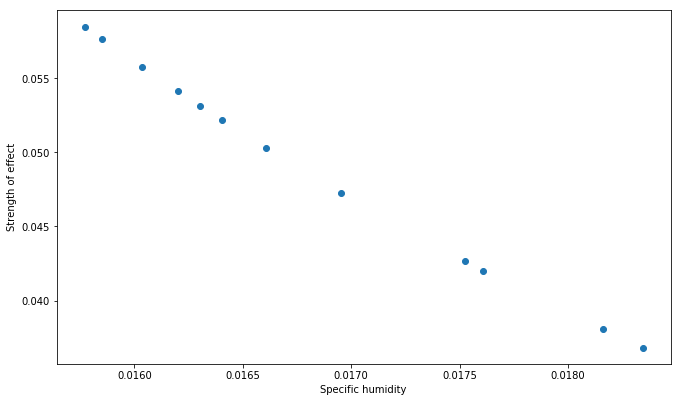

In [78]:
# humidity effect
plt.figure()
plt.plot(climate.HUMIDITY_DATA, np.exp(-180*climate.HUMIDITY_DATA), 'o')
plt.xlabel("Specific humidity")
plt.ylabel("Strength of effect")

We see that the size of the effect towards $R_{0, max}$ is around 0.05. This means that the average $R_0$ will be around $R_{0,min} + 0.05R_{0,max}$. Getting the critical value with $R_{0,min} = 1.1$ means that we expect $R_{0,max} \approx 1.3$. 

So for values of $R_{0,max} > 1.3$, we would expect that the system does not display eardication behaviour.

We know that $R_{0, crit} \approx 1.16$, so we can set up a simulation with $R_{0, min} = 1.1, R_{0, max} = 2.4$.

In [79]:
critical_parameters = [0.01, 0.9, 1.1, 2.4, 0.99, 0.6, 180]

def modelfn_critical(t, y):
    return climate.model(t, y, critical_parameters, [0, 0])

solution_ct = integrate.solve_ivp(modelfn_critical, [0, 200], 
                                  [1-infected_fraction, infected_fraction, 0, climate.Q0, 0], 
                                  max_step=1/12, dense_output=True)
solution_ct.message

'The solver successfully reached the end of the integration interval.'

In [80]:
T = solution_ct.t
S, I, R, Q, L = solution_ct.y

Text(0.5, 1.0, 'Infected fraction over time')

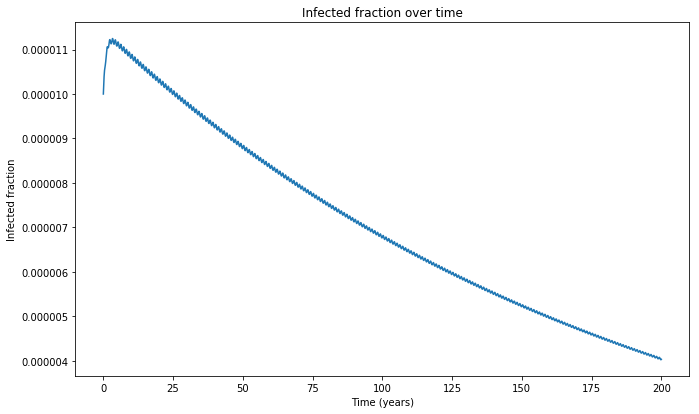

In [81]:
plt.figure()
plt.plot(T, I)
plt.xlabel("Time (years)")
plt.ylabel("Infected fraction")
plt.title("Infected fraction over time")

Let's perform a crude continuation experiment, as we change $R_{0,max}$ and see the final value as $t \to 1000$.

We will explore over the range 1.2 to 5.2

In [119]:
final_is = []
for r0max in np.linspace(1.2, 5.2, 100):
    p = [0.01, 0.9, 1.1, r0max, 0.99, 0.6, 180]
    def model(t, y):
        return climate.model(t, y, p, [0, 0])
    sol = integrate.solve_ivp(model, [0, 1000], 
                                  [1-infected_fraction, infected_fraction, 0, climate.Q0, 0], 
                                  max_step=1/12)
    final_is.append((r0max, sol.y[1, -1]))
final_is = np.array(final_is)

Text(0.5, 1.0, 'Infected proportion at $t=1000$ years')

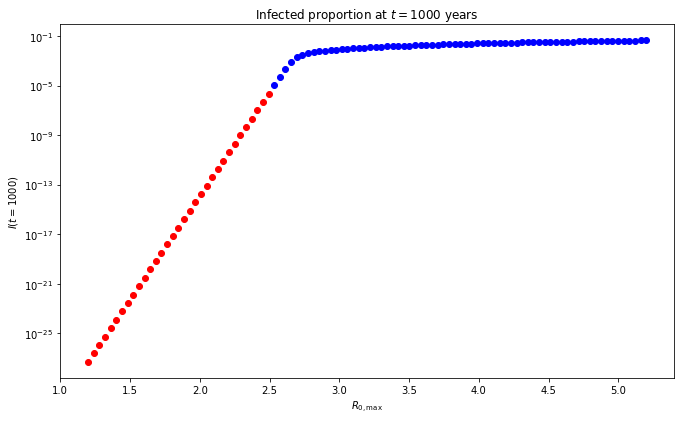

In [122]:
threshold=1e-5 #heuristic determination of stability
plt.figure()
plt.semilogy(*final_is[[True if f[1]>=threshold else False for f in final_is ],:].T, 'bo')
plt.semilogy(*final_is[[True if f[1]<threshold else False for f in final_is ],:].T, 'ro')
plt.xlabel(r"$R_{0,\max}$")
plt.ylabel(r"$I(t=1000)$")
plt.title("Infected proportion at $t=1000$ years")

There is a distinct change in the gradient of the plot just past $R_{0,max} = 2.5$ This is where we suspect the bifurcation to occur. What is interesting is that this is very different from the value we estimated above. We also see that the change occurs past the point where $I(1000) = 1e-5$ This is likely due to the behaviour where the infected proportion increases to a large value and slowly recedes to $I=0$.